# Среднемесячный уровень заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. 

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


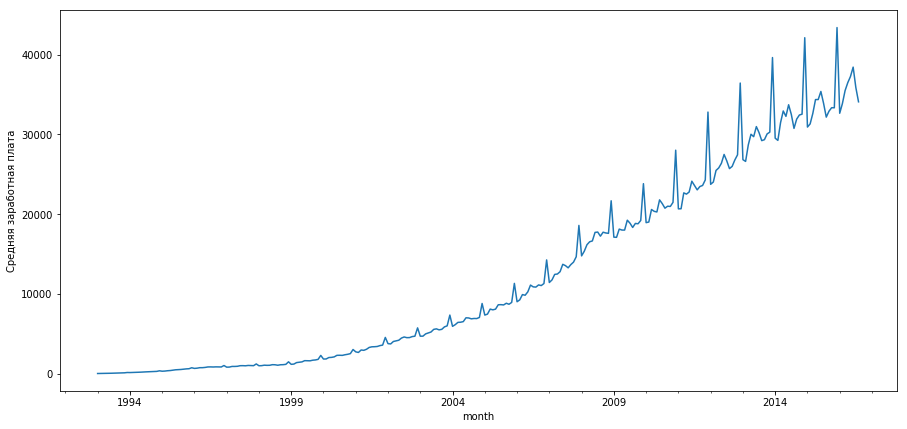

In [9]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()
#wine.sales = wine.sales * 1000
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel(u'Средняя заработная плата')
pylab.show()

В данных прослеживается восходящий тренд, а также цикличность в течение года

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

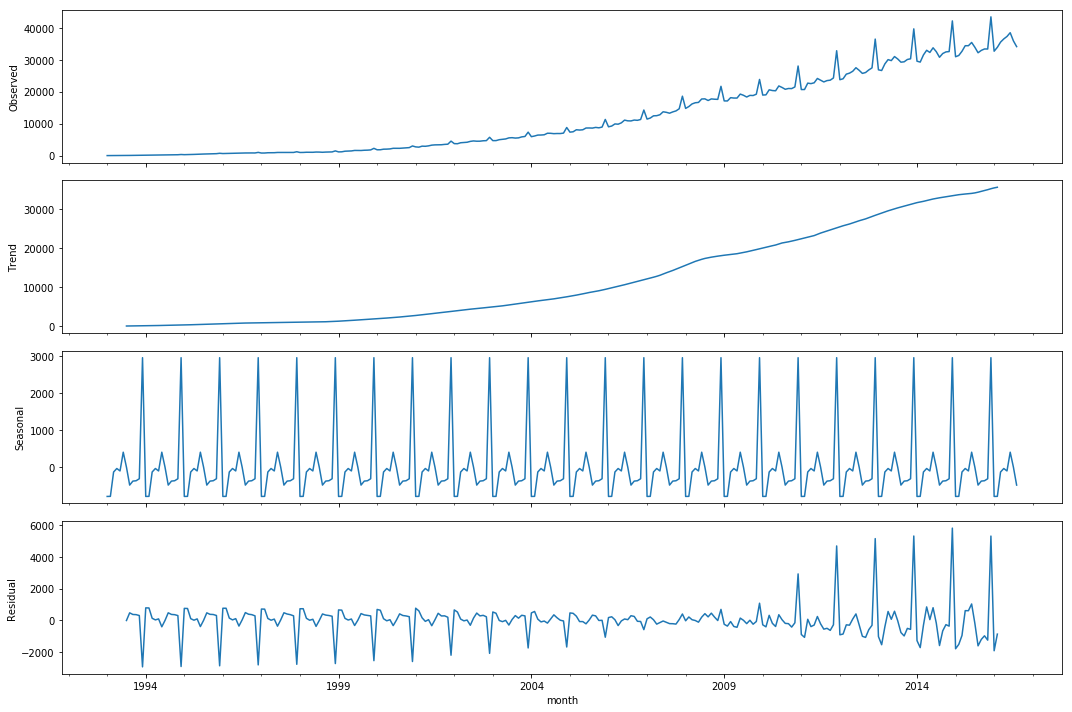

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

По результатам гипотеза о нестационарности ряда неотвеграется, но по данным видно, что это не так. Дисперсия возрастает с годом. Поэтому требуется стабилизацияя дисперии.

Также на графиках видим подтверждаение цикличности и возрастающего тренда. 

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


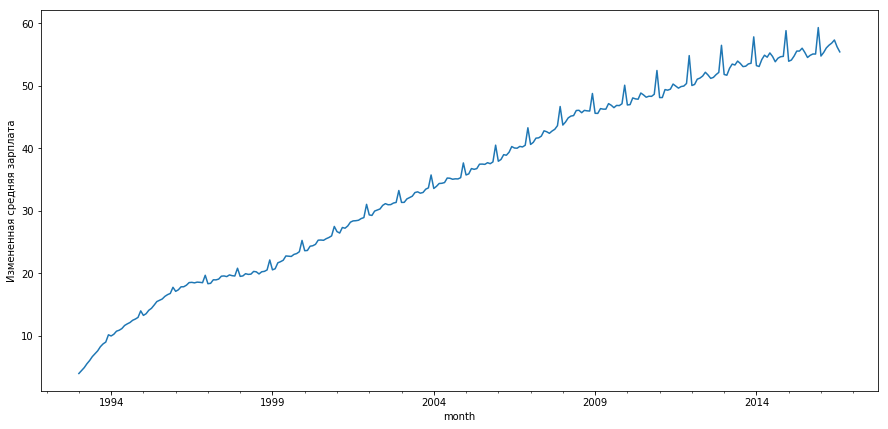

In [12]:
data['wag_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_box.plot()
plt.ylabel(u'Измененная средняя зарплата')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box)[1])

### Стационарность

Критерий Дики-Фуллера все еще отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

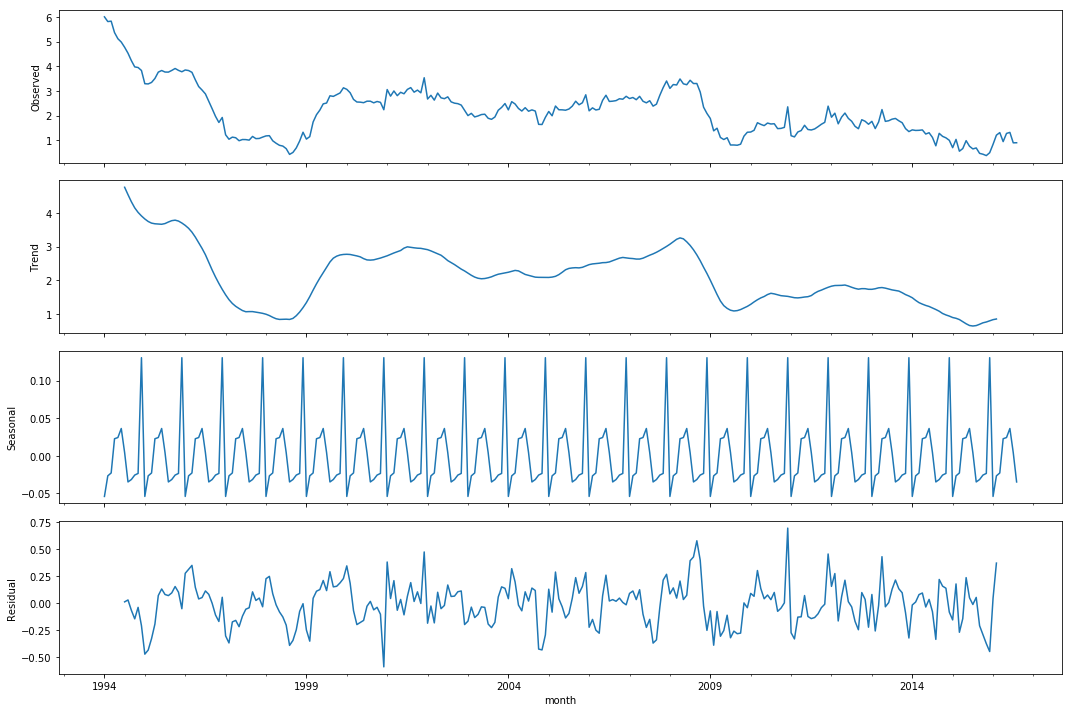

In [13]:
data['wag_box_diff'] = data.wag_box - data.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но по графику видно, полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

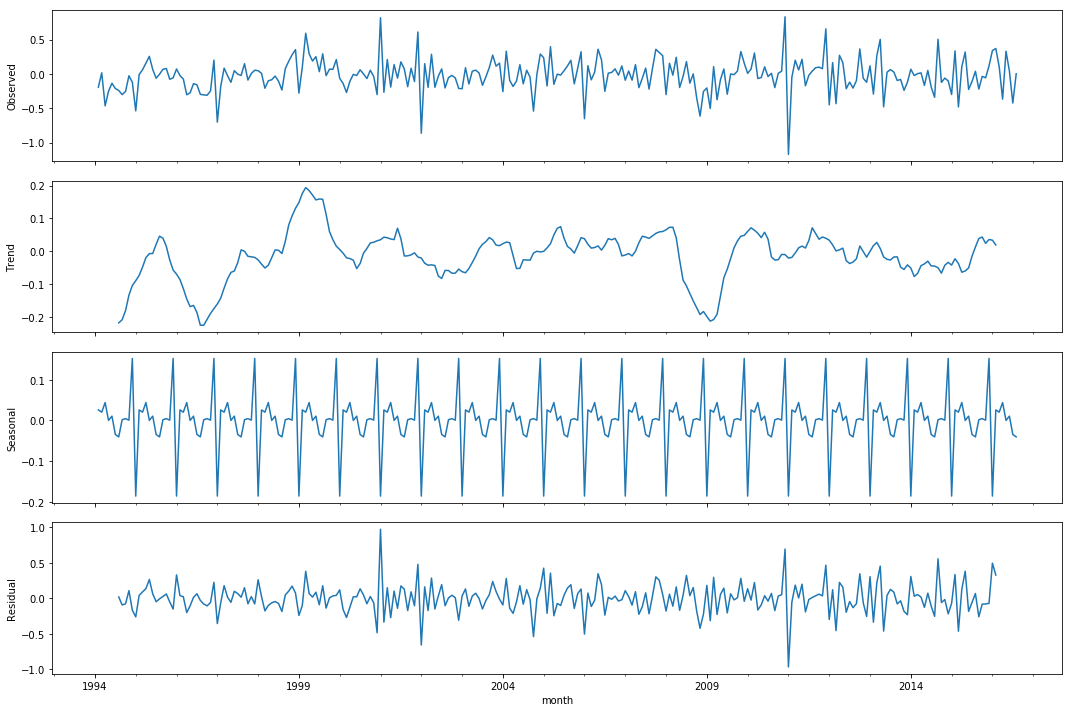

In [15]:
data['wag_box_diff2'] = data.wag_box_diff - data.wag_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

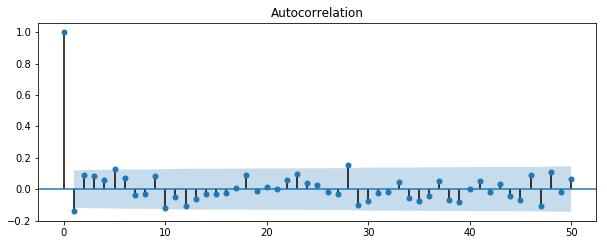

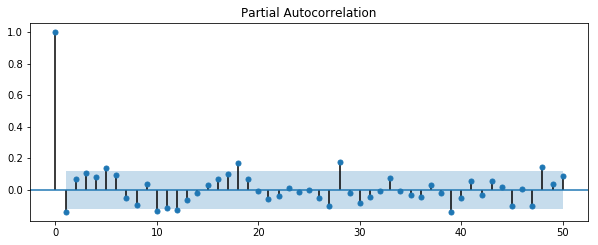

In [24]:
plt.figure(figsize(10,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

ПО графику автокорреляции видим, что сезонных лагов со значимой корреляцией нет. 
Максимальный значимый несезонный лаг - 1.
По графику частичной автокорреляционной функции видно, что для сезонных лагов максимальная значимая - 48. Возьмем P = 4. 
Для несезонных возьмем p = 5, т.к. выбирамем так, чтобы он был максимальным, но при этом не сильно большим, чтобы модели обучались адекватное количество времени
Начальные приближения: Q=0, q=1, P=4, p=10.
Дифференцирование обычное и по сезону производили по 1, поэтому d = 1, D = 1

In [31]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [32]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [34]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
Wall time: 2min 30s


In [35]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
51  (5, 1, 1, 0) -5.260133
31  (3, 1, 1, 0) -4.995860
46  (5, 0, 1, 0) -4.545934
54  (5, 1, 4, 0) -4.469894
49  (5, 0, 4, 0) -4.238184


Лучшая модель оказалась с параметрами: 5, 1, 1, 0.

In [36]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Fri, 14 Dec 2018   AIC                             -5.260
Time:                                    14:39:33   BIC                             23.557
Sample:                                01-01-1993   HQIC                             6.310
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2017      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

Её остатки:

Критерий Стьюдента: p=0.296170
Критерий Дики-Фуллера: p=0.000000


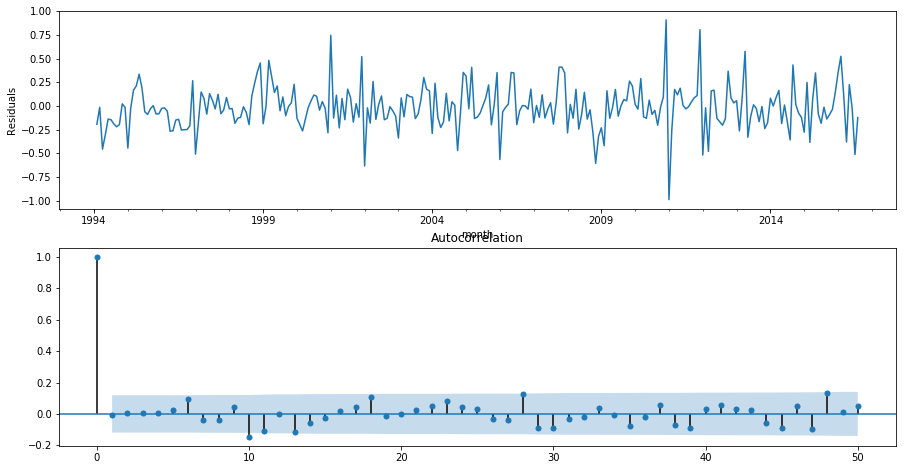

In [37]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

#Проверяем несмещенность и стационарность остатков
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

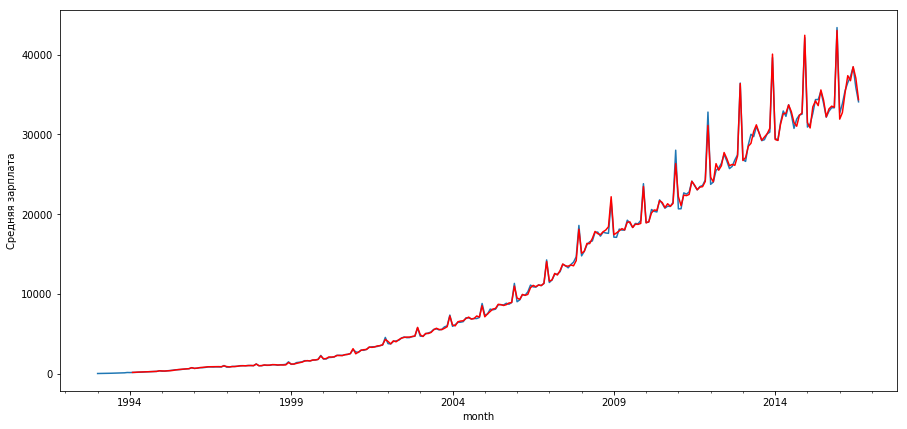

In [38]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Средняя зарплата')
pylab.show()

Модель хорошо описывает исходные данные. Прогноз выглядит адекватным: 

### Прогноз

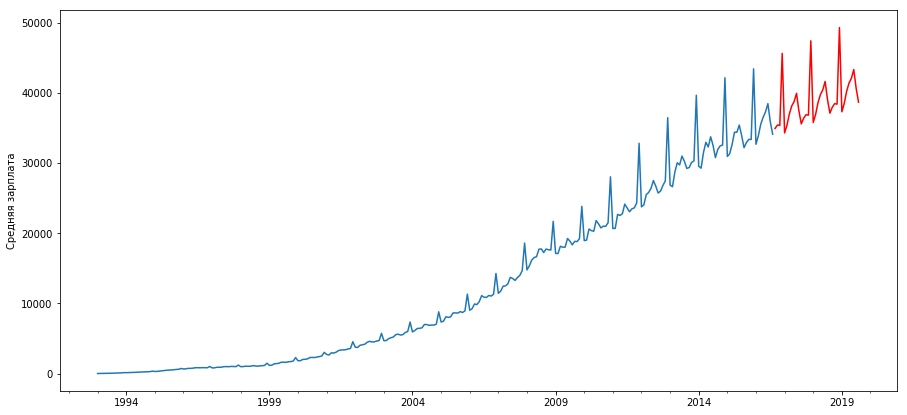

In [50]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index = date_list, columns = data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'Средняя зарплата')
pylab.show()